<a href="https://colab.research.google.com/github/Stedjey/Classification-of-Writers-Texts/blob/main/github_%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D0%BF%D0%B8%D1%81%D0%B0%D1%82%D0%B5%D0%BB%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
drive.mount('/content/drive')

In [ ]:
#Задаём базовые параметры
xLen = 7000 #Длина отрезка текста, по которой анализируем, в словах
step = 200 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
cur_time = time.time() # Засекаем текущее время
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

cur_time = time.time() # Засекаем текущее время
#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
#получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

cur_time = time.time() # Засекаем текущее время
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #П одаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100]) # Фрагмент набора слов в виде Bag of Words
print('Время обработки: ', round(time.time() - cur_time, 2), 'c', sep='')

Время обработки: 2.59c
Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [688, 22, 1, 5977, 93, 2, 1, 7217, 7, 379, 1, 5, 385, 2, 5, 787, 1954, 8, 246, 18266] 

(8855, 7000)
(8855, 6)
(3231, 7000)
(3231, 6)
Время обработки: 6.84c
(8855, 20000)
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
Время обработки: 23.97c


Epoch 1/10
70/70 [==============================] - 1s 14ms/step - loss: 0.1745 - accuracy: 0.9805 - val_loss: 0.1724 - val_accuracy: 0.9647
Epoch 2/10
70/70 [==============================] - 1s 11ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1647 - val_accuracy: 0.9712
Epoch 3/10
70/70 [==============================] - 1s 12ms/step - loss: 6.3958e-04 - accuracy: 1.0000 - val_loss: 0.1644 - val_accuracy: 0.9731
Epoch 4/10
70/70 [==============================] - 1s 11ms/step - loss: 4.2584e-04 - accuracy: 1.0000 - val_loss: 0.1614 - val_accuracy: 0.9734
Epoch 5/10
70/70 [==============================] - 1s 11ms/step - loss: 2.7543e-04 - accuracy: 1.0000 - val_loss: 0.1588 - val_accuracy: 0.9731
Epoch 6/10
70/70 [==============================] - 1s 11ms/step - loss: 2.1453e-04 - accuracy: 1.0000 - val_loss: 0.1589 - val_accuracy: 0.9721
Epoch 7/10
70/70 [==============================] - 1s 11ms/step - loss: 1.6733e-04 - accuracy: 1.0000 - val_loss: 0.1544 - val_accuracy: 

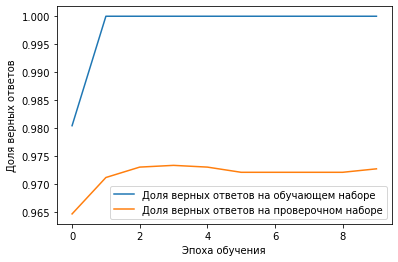

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
#Слой пакетной нормализации
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(300,  activation="relu"))
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model01.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               4000200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800       
_________________________________________________________________
dense_4 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                

In [ ]:
xTest6Classes01, x2 = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 100% сеть отнесла к классу СтругацкиеЭто ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   100% сеть отнесла к классу Булгаков  Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     100% сеть отнесла к классу Саймак    Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       91% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 97%

